# Multi-Label k-Nearest Neighbors

In [1]:
%matplotlib notebook 
import numpy as np
import pandas as pd
import ast
import json
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns


### Load Data

In [2]:
# get the data
all_data = pd.read_csv('train.csv')
all_data = all_data.dropna(subset=['overview', 'genres']) #drop cols without overview or genre (data we use or labels)
genre_set = {'Comedy'}

In [3]:
# drop all irrelevant columns
all_data = all_data.drop(columns=['id', 'belongs_to_collection', 'budget','homepage','imdb_id','original_language','original_title','popularity','poster_path','production_companies','production_countries','release_date','runtime','spoken_languages','status','tagline','title','Keywords','cast','crew','revenue'])

### Preprocess Data
<ul>
    <li>Get all possible genres.</li>
    <li>Vectorize Genres:</li>
    <ul>
        <li>Save genres as a vector of 0s and 1s.</li>
        <li>Save genres as list of strings.</li>
    </ul>
    <li>Separete genres into binary columns.</li>
    <li>Drop columns no longer needed.</li>
</ul>

In [4]:
# preprocessing functions
def text_to_list(x):
    if pd.isna(x):
        return ''
    else:
        return ast.literal_eval(x)

    
def parse_json(x):
    try:
        return json.loads(x.replace("'", '"'))[0]['name']
    except:
        return ''
    
    
def parse_all_genres_json(x):
    try:
        json_genres = json.loads(x.replace("'", '"'))
        numElems = len(json_genres)
        for i in range(numElems):
            genre_set.add(json_genres[i]['name'])
    except:
        return ''
    
    
def parse_genres_json(x):
    try:
        json_genres = json.loads(x.replace("'", '"'))
        numElems = len(json_genres)
        ret = [0]*len(genre_dict) #20 0s
        for i in range(numElems):
            ret[genre_dict[(json_genres[i]['name'])]] = 1
        return ret
    except:
        return ''
    

def get_labels_as_strs(x):
    try:
        json_genres = json.loads(x.replace("'", '"'))
        numElems = len(json_genres)
        ret = []#20 0s
        for i in range(numElems):
            ret.append(json_genres[i]['name'])
        return ret
    except:
        return ''

In [5]:
# generate list of genres
def getAllGenres():
    full_data = pd.read_csv('train.csv')
    y = full_data['genres']
    y.apply(parse_all_genres_json)

In [6]:
getAllGenres()

In [7]:
#get set to dictionary for indexing of target vectors
genre_dict = {}
index = 0
for genre in genre_set:
    genre_dict[genre] = index
    index += 1

In [8]:
# vectorize genres
def getGenresVects():
    y = all_data['genres']
    ret = y.apply(parse_genres_json)
    all_data['genres_vect'] = ret
    label_strs = y.apply(get_labels_as_strs)
    all_data['genres_labels'] = label_strs
    return 

In [9]:
getGenresVects()

In [10]:
# modify data for 6 categories instead of 20
action_adventure = []
comedy = []
drama = []
horror_triller = []
romance = []
scifi_fantasy = []

# loop through all rows
for i in range(all_data.shape[0]):
    # get the labels
    labels = all_data.iloc[i,3]
    # append a 1 if the genre is in the labels, and a 0 otherwise
    # reducing number of categories and combining very similar categories
    # that are usually together
    if 'Action' in labels:
        action_adventure.append(1)
    elif 'Adventure' in labels:
        action_adventure.append(1)
    else:
        action_adventure.append(0)

    if 'Comedy' in labels:
        comedy.append(1)
    else:
        comedy.append(0)

    if 'Drama' in labels:
        drama.append(1)
    else:
        drama.append(0)

    if 'Horror'in labels:
        horror_triller.append(1)
    elif 'Thriller'in labels:
        horror_triller.append(1)
    else:
        horror_triller.append(0)

    if 'Romance'in labels:
        romance.append(1)
    else:
        romance.append(0)

    if 'Science Fiction'in labels:
        scifi_fantasy.append(1)
    elif 'Fantasy' in labels:
        scifi_fantasy.append(1)
    else:
        scifi_fantasy.append(0)
        
# set new column in data frame to be lists just generated above
all_data["Action-Adventure"] = action_adventure
all_data["Comedy"] = comedy
all_data["Drama"] = drama
all_data["Horror-Thriller"] = horror_triller
all_data["Romance"] = romance
all_data["SciFi-Fantasy"] = scifi_fantasy

categories = ['Action-Adventure', 'Comedy', 'Drama', 'Horror-Thriller', 'Romance', 'SciFi-Fantasy']

# recheck all rows for genres, and remove rows with none
sum_genres = []
for i in range(all_data.shape[0]):
    row = all_data.iloc[i]
    sum_row = 0
    for category in categories:
        if row[category] == 1:
            sum_row = 1
    if sum_row == 0:
        sum_genres.append(None)
    else:
        sum_genres.append(sum_row)
        
all_data["numGenres"] = sum_genres
all_data = all_data.dropna(subset=['numGenres']) 

In [11]:
# drop columns no longer needed
data = all_data.drop(columns=['genres','genres_vect','genres_labels','numGenres'])

In [12]:
categories = list(data.columns.values)

### Generate Bar Plots for data visualization
<ul>
    <li>Number of Movies in Each Genre</li>
    <li>Number of Movies in Reduced Genres</li>
    <li>Number of Movies with Multiple Labels</li>
    <li>Number of Movies with Multiple Labels in Reduced Genres</li>
</ul>

<IPython.core.display.Javascript object>


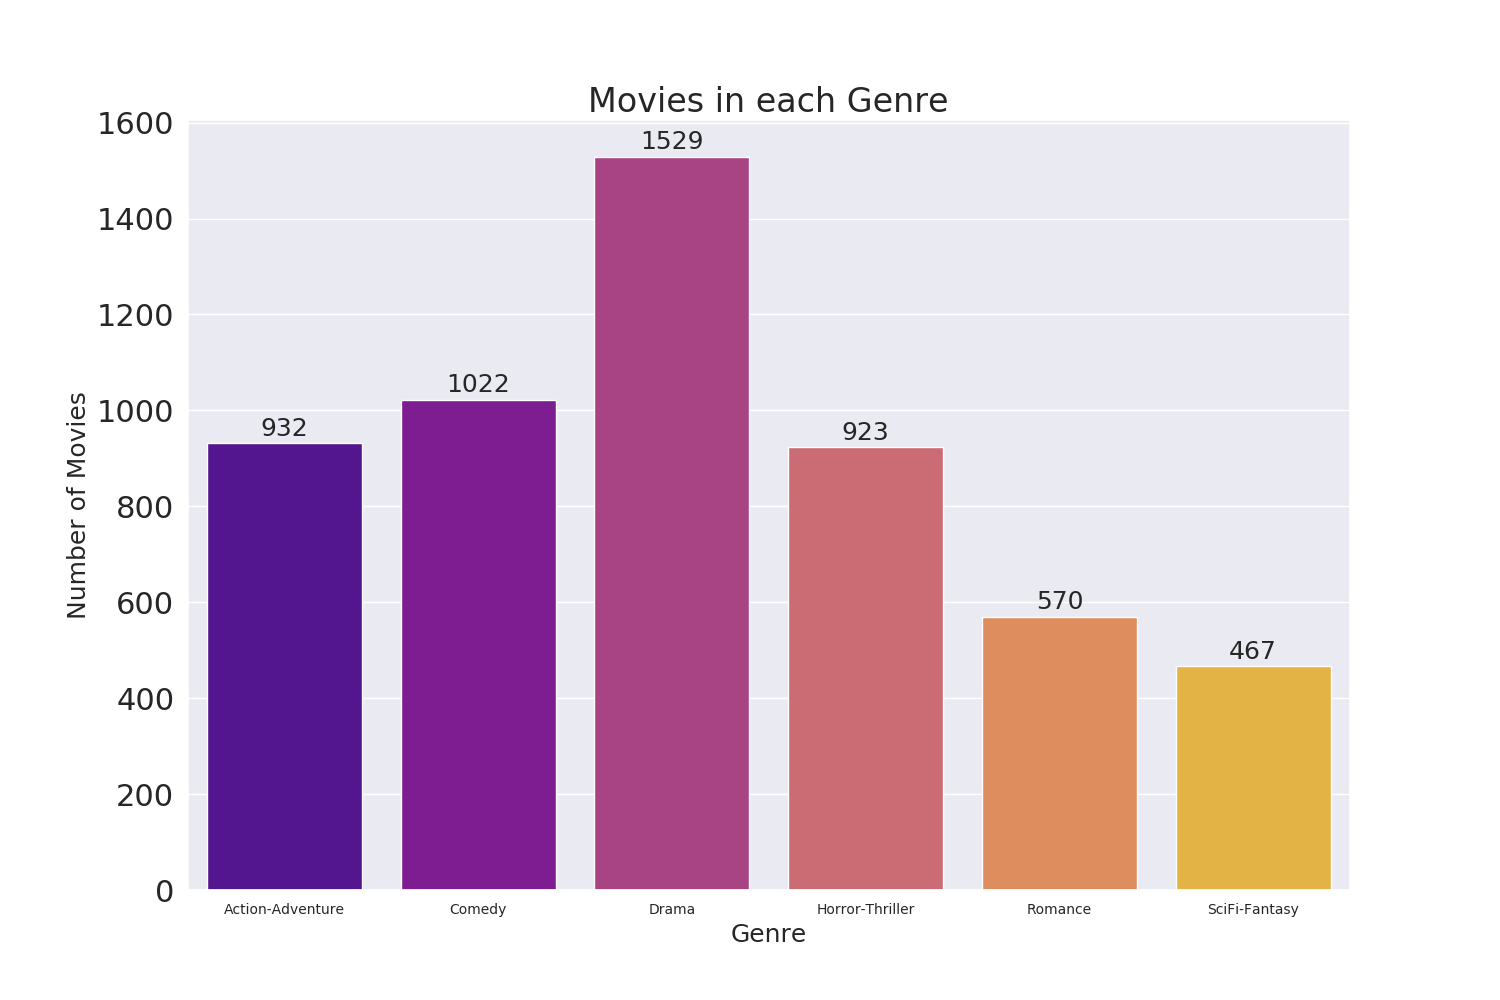

In [13]:
# plot movies in each genre (6)
sns.set(font_scale=2)
plt.figure(figsize=(15,10))


y = data.iloc[:,1:].sum().values

ax= sns.barplot(categories[1:], y, palette="plasma")
plt.title("Movies in each Genre", fontsize=24)
plt.ylabel('Number of Movies', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(fontsize=10)

rects = ax.patches
labels = data.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

<IPython.core.display.Javascript object>


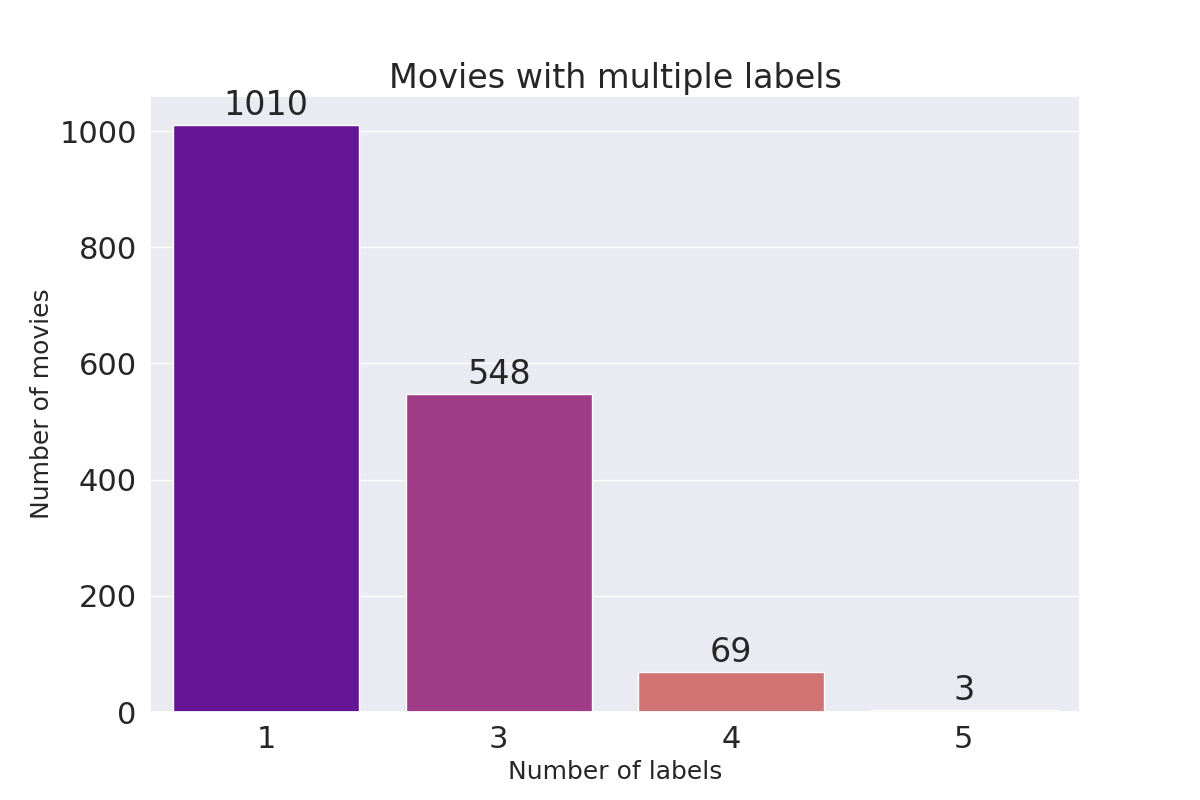

In [14]:
# plot how many movies with multiple labels (in 6)
row_sums = data.iloc[:,1:].sum(axis=1)
multilabel_counts = row_sums.value_counts()
multilabel_counts = multilabel_counts.iloc[1:]

sns.set(font_scale=2)
plt.figure(figsize=(12,8))

ax = sns.barplot(multilabel_counts.index, multilabel_counts.values, palette="plasma")

plt.title("Movies with multiple labels")
plt.ylabel('Number of movies', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

rects = ax.patches
labels = multilabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha='center', va='bottom')
    
plt.show()

### Generate Word Clouds for Genre Visualization
Word Clouds for:
<ul>
    <li>Action-Adventure Movies</li>
    <li>Drama Movies</li>
</ul>

<IPython.core.display.Javascript object>


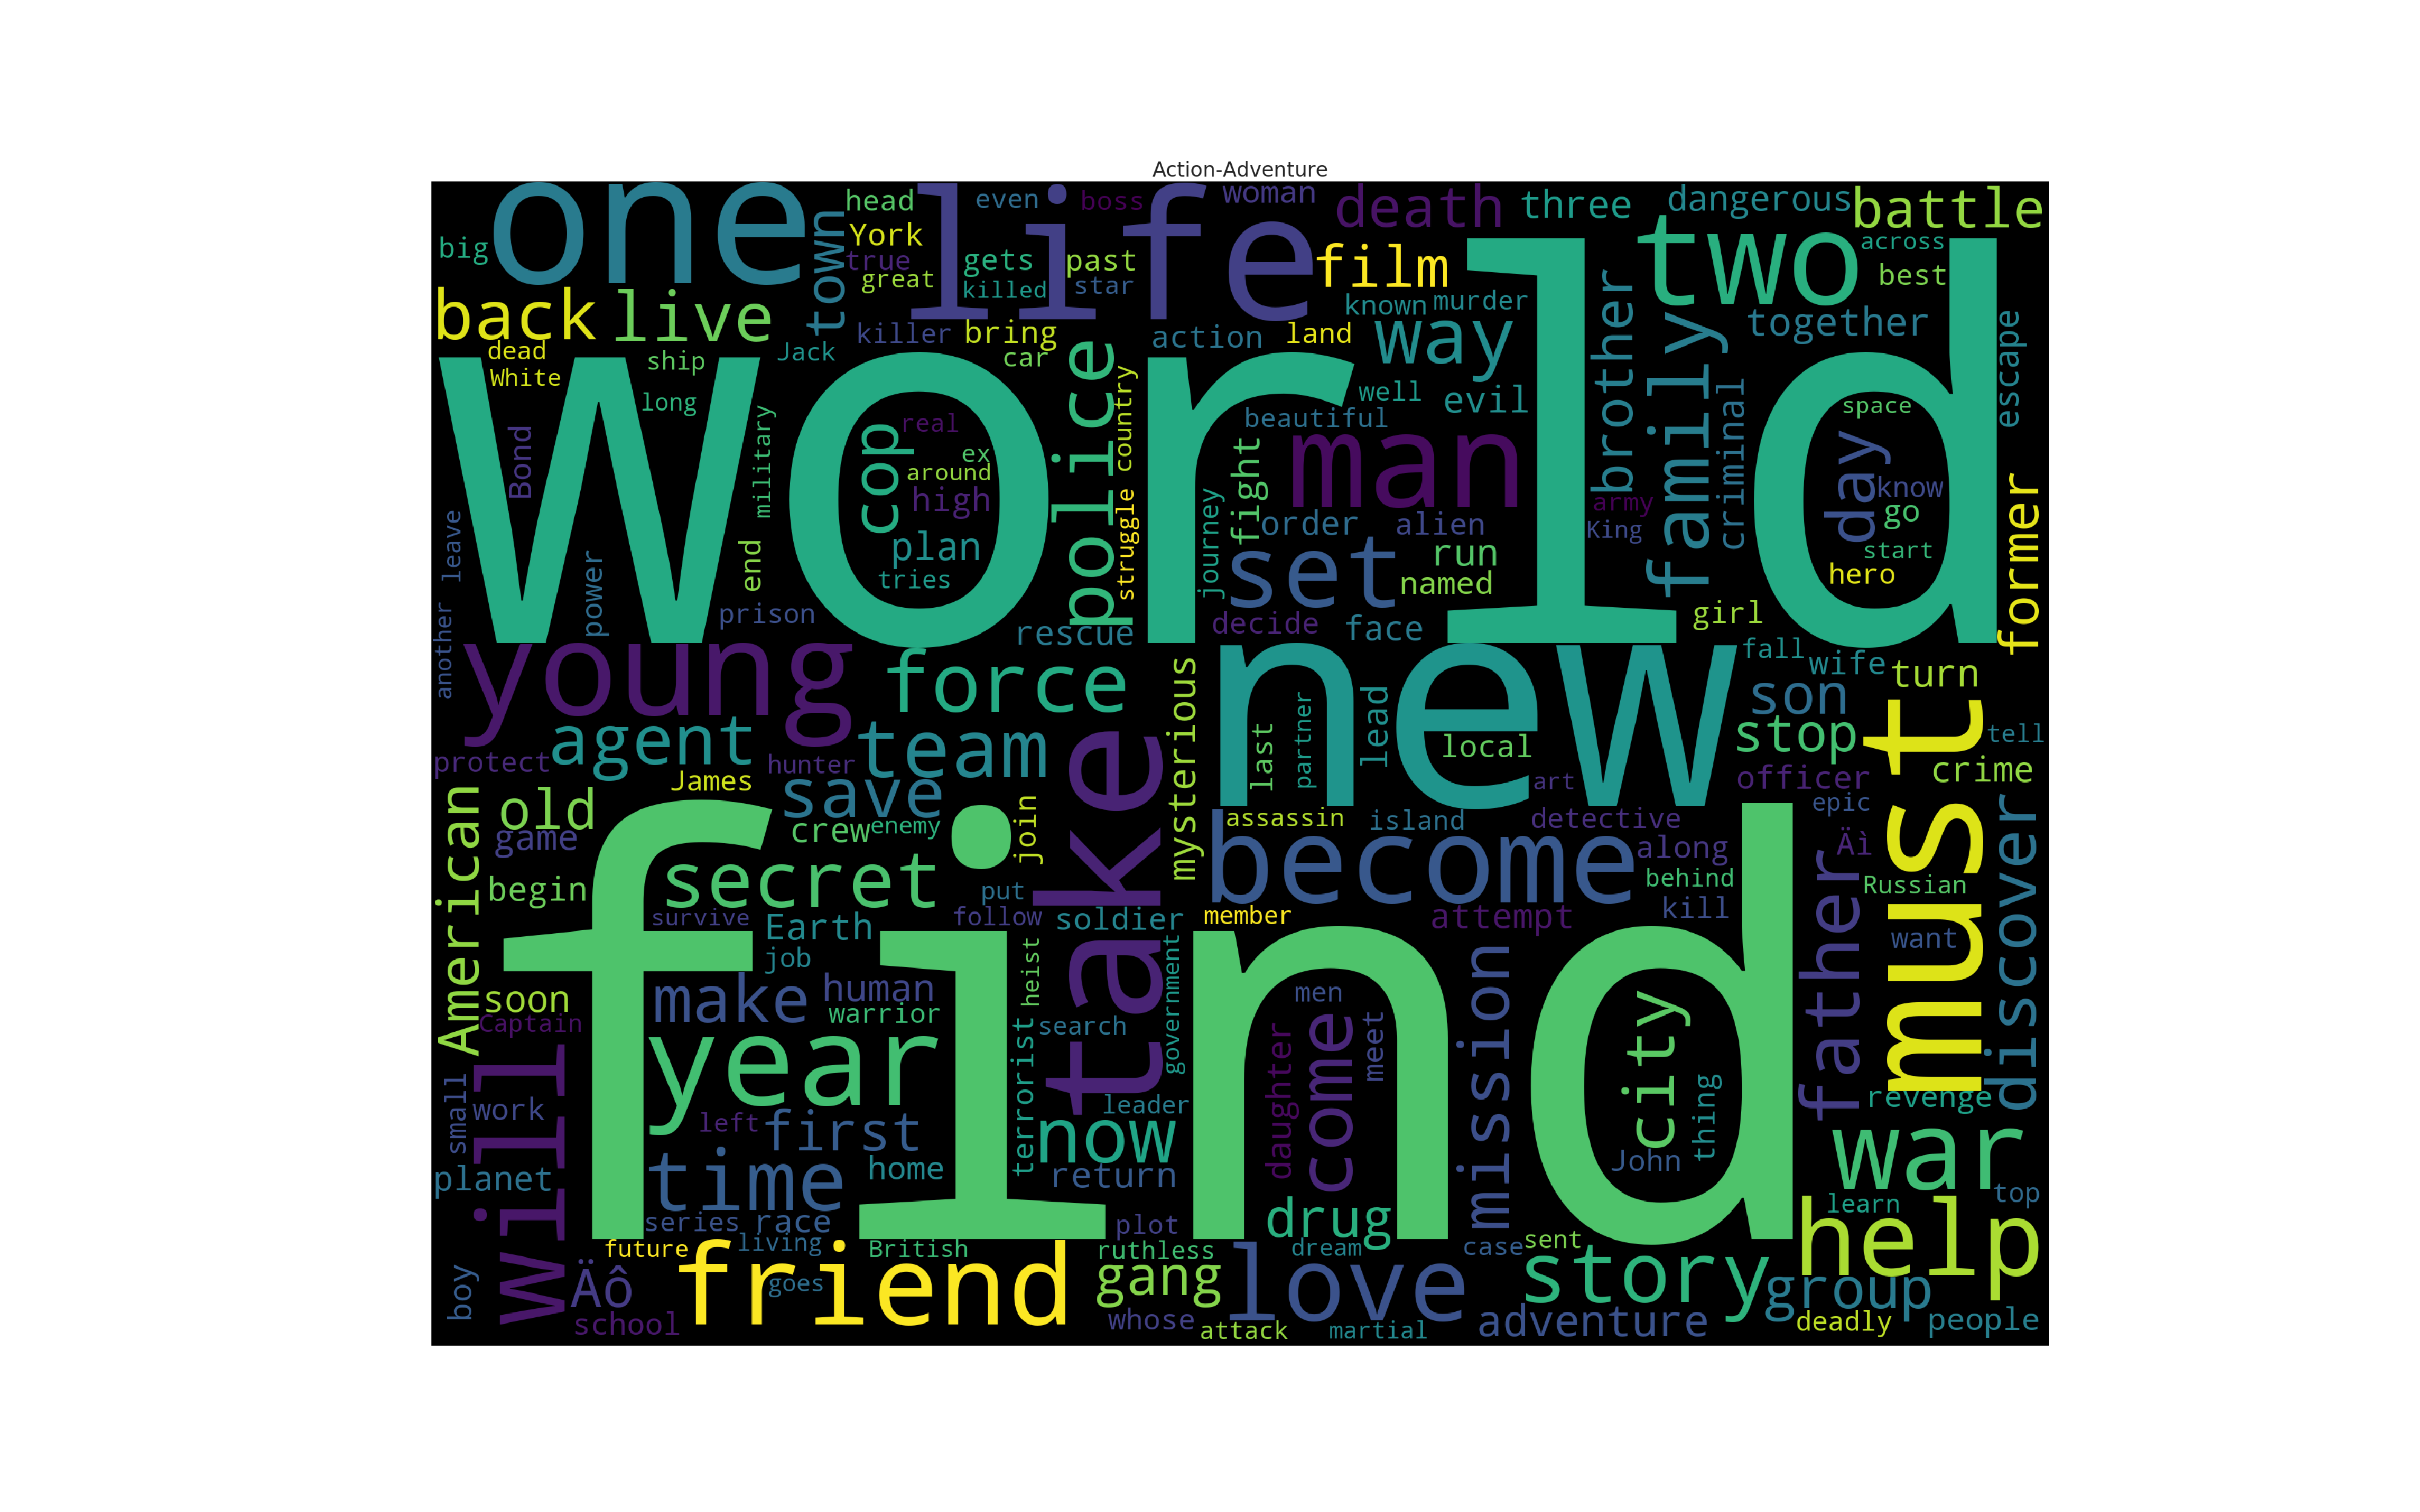

In [15]:
#plot word cloud for action-adventure category
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(40,25))

subset = data[data['Action-Adventure'] == True]
text = subset.overview.values
cloud_genre = WordCloud(stopwords=STOPWORDS, 
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Action-Adventure")
plt.imshow(cloud_genre)

<IPython.core.display.Javascript object>


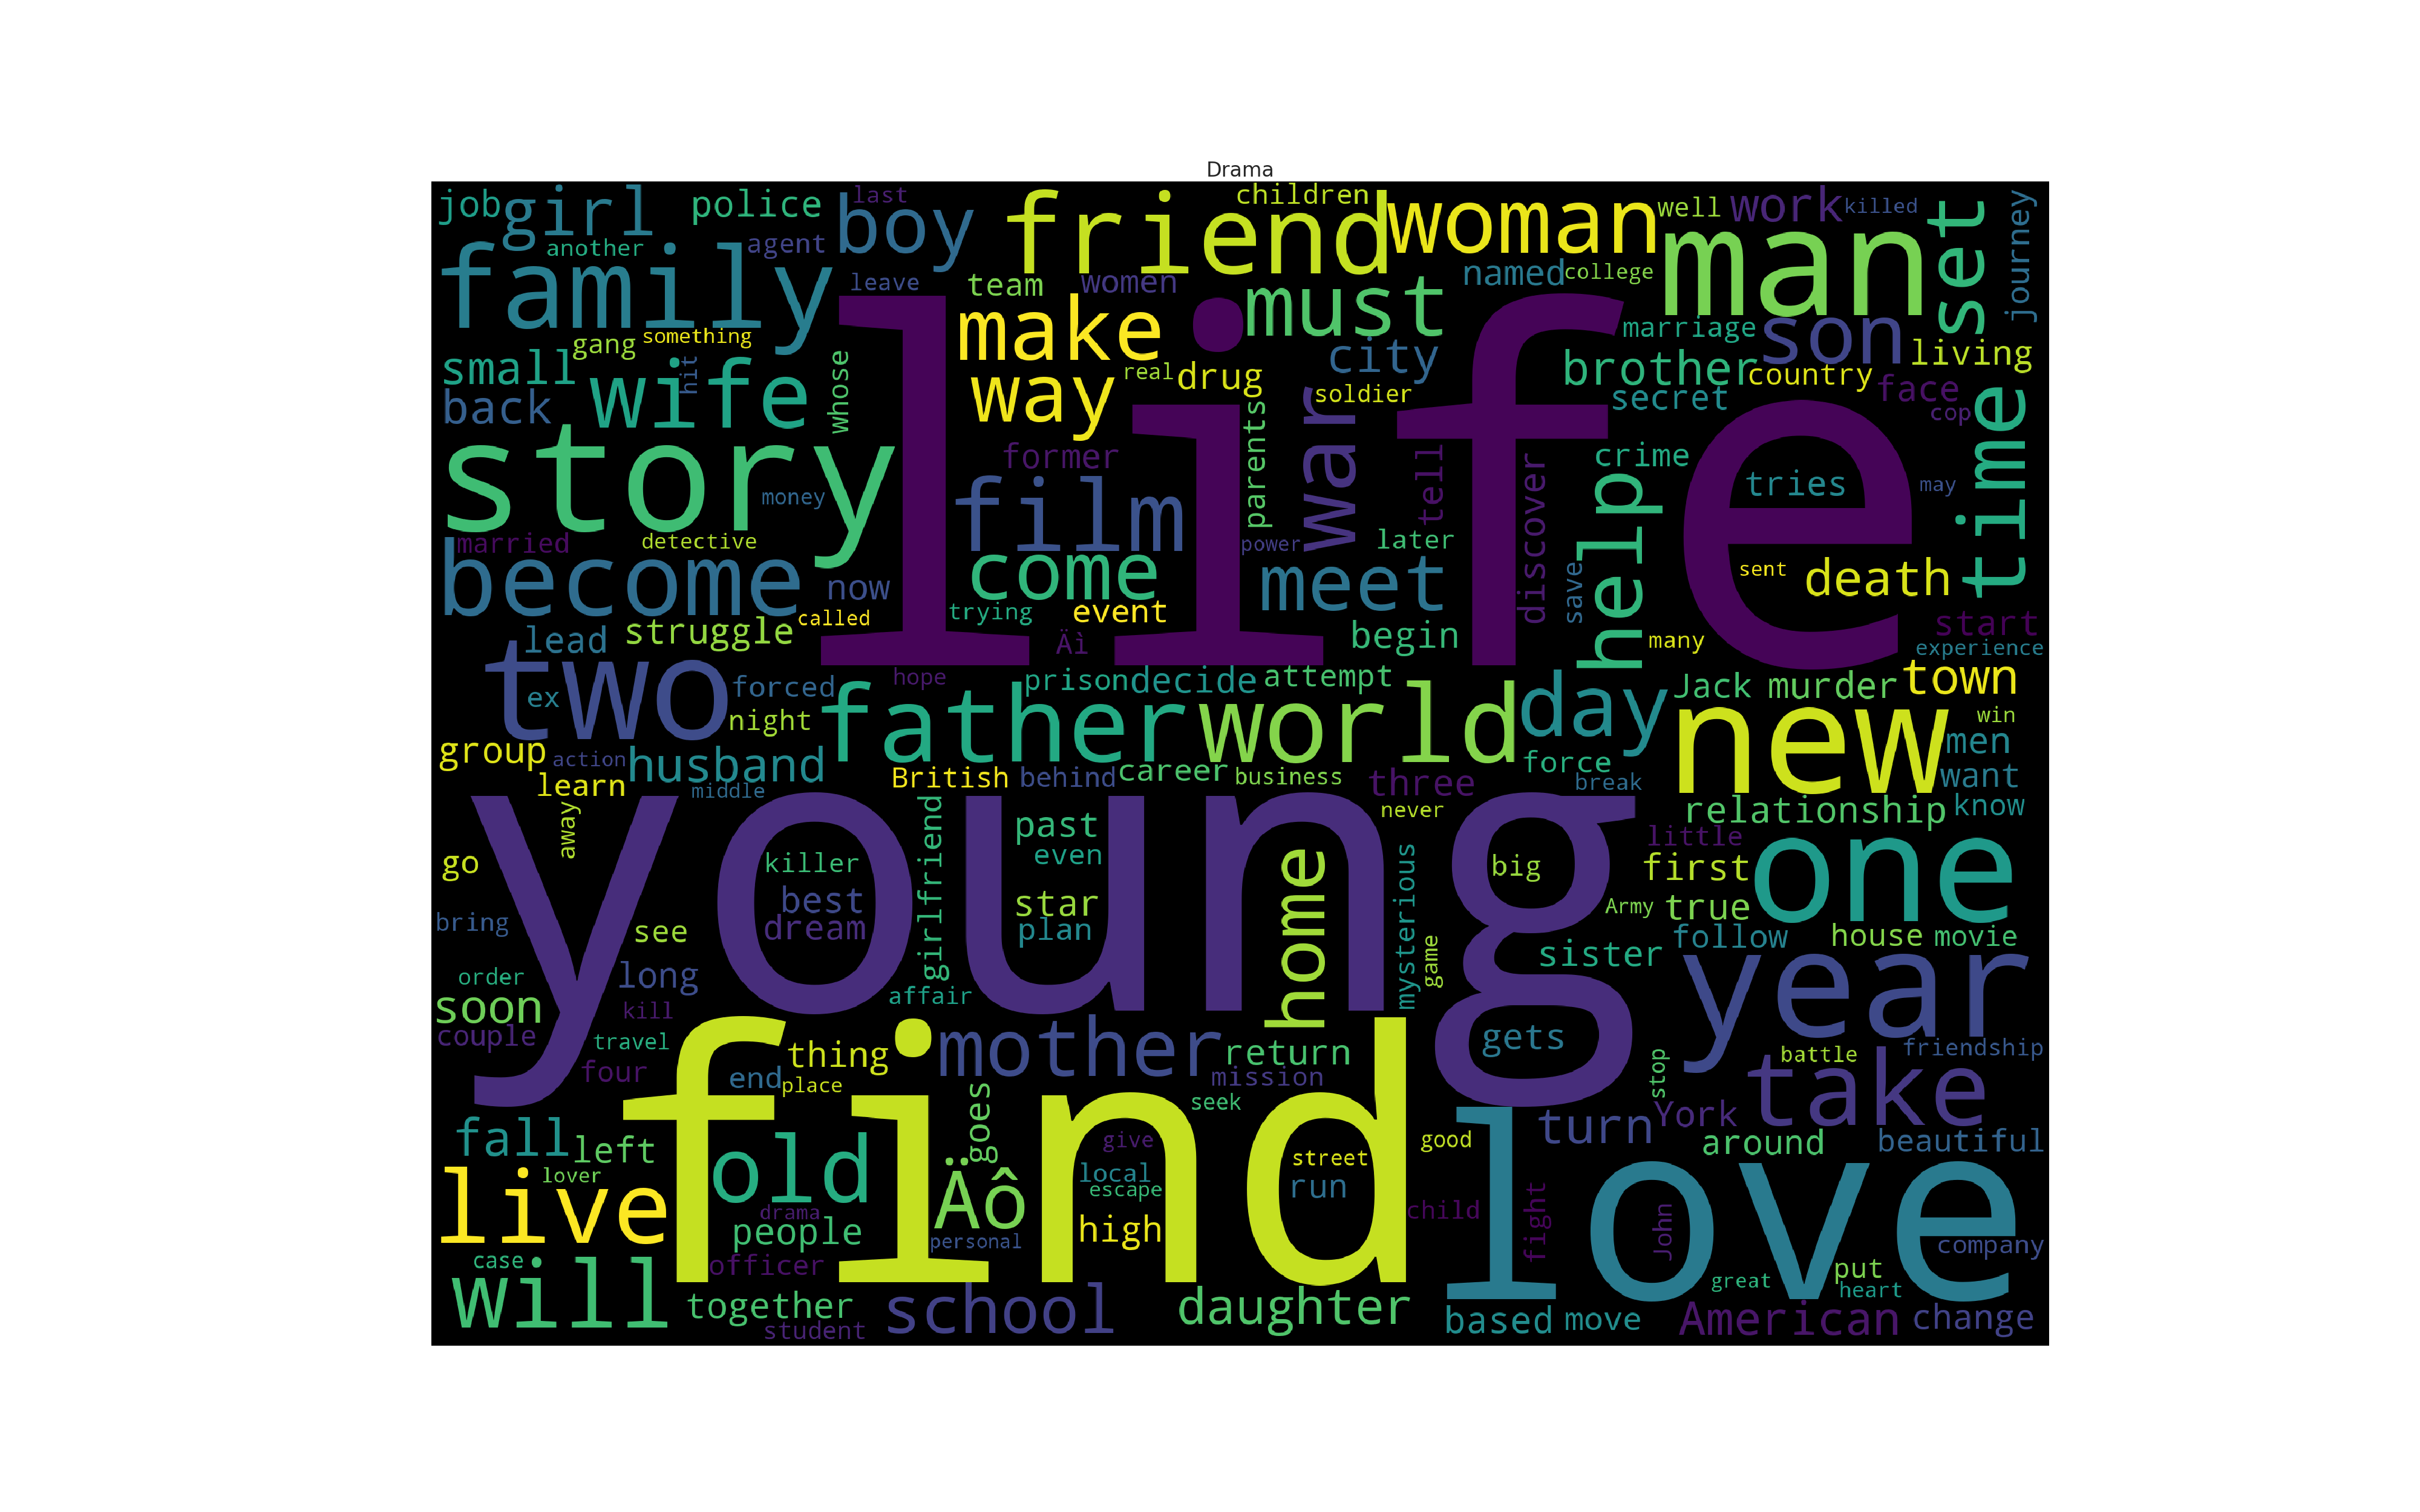

In [16]:
#plot word cloud for Drama category
from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize=(40,25))

subset = data[data['Drama'] == True]
text = subset.overview.values
cloud_genre = WordCloud(stopwords=STOPWORDS, 
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Drama")
plt.imshow(cloud_genre)

### Process Overview Category
Processing:
<ul>
    <li>Remove punctuation</li>
    <li>Set to lowercase</li>
    <li>Remove StopWords -> words that are common in the english language</li>
    <ul><li>Ex. the, a, etc.</li></ul>
    <li>Stem words -> reduce to root words</li>
</ul>

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import re
import sys
import warnings

In [18]:
df = data
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
#put to lower case, remove punctation
def cleanText(text):
    text = re.sub(r'[^a-z A-Z 0-9]', "", text) #maybe shouldn't remove punction between words here?
    text = text.lower()
    return text
df['overview'] = df['overview'].apply(cleanText)

In [19]:
stop_words = set(stopwords.words('english'))
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

# remove common words in the english langauge (like the, a, etc.)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

df['overview'] = df['overview'].apply(removeStopWords)

In [20]:
stemmer = SnowballStemmer("english")

# reduce words to the root i.e. running -> run
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

df['overview'] = df['overview'].apply(stemming)

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42, test_size=0.2, shuffle=True)

### Vectorize Overview

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize strings to be interpreted by knn
X_train = train['overview']
y_train = train[1:]

X_test = test['overview']
y_test = test[1:]

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
# vectorie all data
vectorizer.fit(X_train)
vectorizer.fit(X_test)
vectorizer.fit(y_train)
vectorizer.fit(y_test)

X_train = vectorizer.transform(X_train)
y_train = train.drop(labels=['overview'], axis=1)

X_test = vectorizer.transform(X_test)
y_test = test.drop(labels=['overview'], axis=1)

### Implement Multi-Label k-Nearest Neighbors
<ul>
    <li>Use k=25 neighbors</li>
    <li>Transform data into list matrices</li>
    <li>Train and Predict</li>
    <li>Display Metrics</li>
</ul>

In [23]:
def last_max(arr):
    mx = arr[0]
    ind_mx = 0
    for i in range(1,len(arr)):
        if arr[i] >= mx:
            mx = arr[i]
            ind_mx = i
    k_ind = ind_mx
    return (k_ind, mx)

In [24]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import lil_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score, KFold

k_range = np.array(range(1,31))
k_scores = []

X_train = lil_matrix(X_train).toarray()
y_train = lil_matrix(y_train).toarray()
X_test = lil_matrix(X_test).toarray()
    
for k in k_range:
    clf = MLkNN(k=k)
    scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

    
mx = last_max(k_scores)
print('Max of list', mx[1])
best_k = mx[0]+1
print(best_k)

Max of list 0.15891210239036324
9


<IPython.core.display.Javascript object>


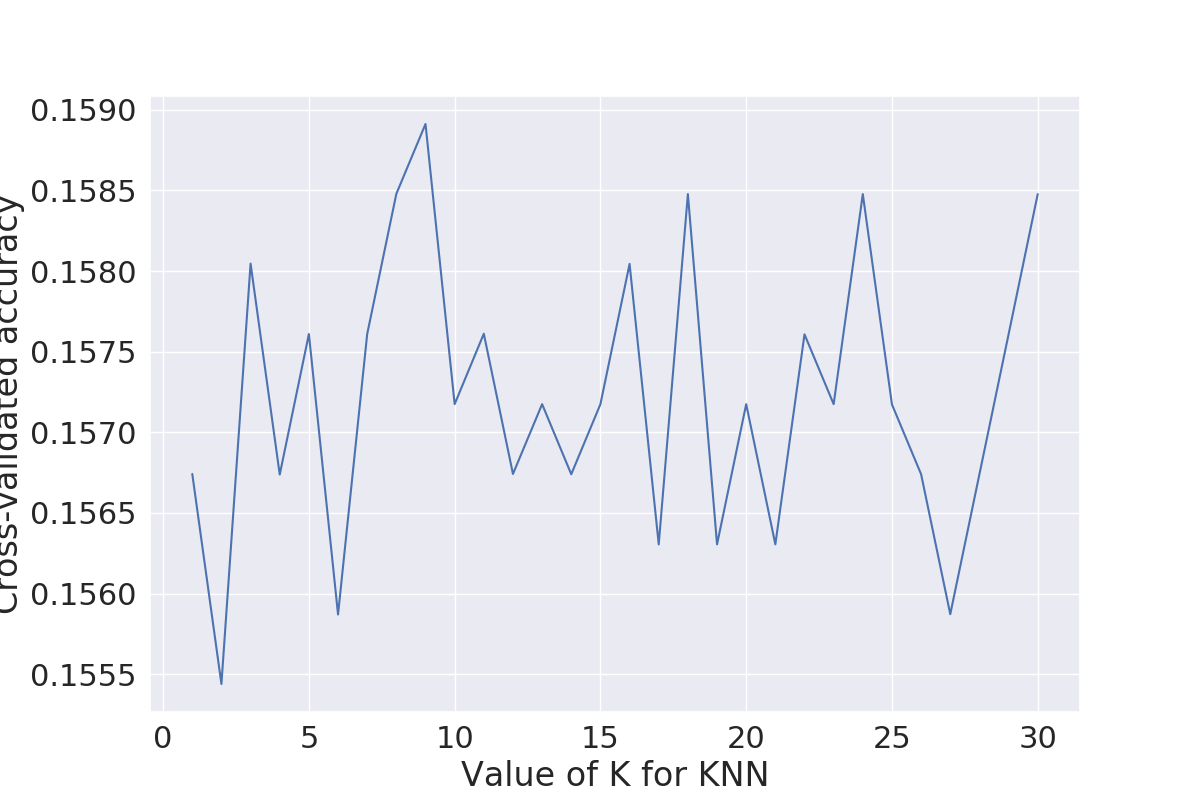

In [25]:
plt.figure(figsize=(12,8))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')
plt.show()

In [26]:
# use Multi-Label k-Nearest Neighbors
classifier = MLkNN(k=best_k)

classifier.fit(X_train, y_train)

predictions = classifier.predict(X_test)

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, predictions) * 100.0))
print("Precision = {:.2f}%".format(precision_score(y_test, predictions, average="samples") * 100.0))
print("Recall = {:.2f}%".format(recall_score(y_test, predictions, average="samples")* 100.0))

Accuracy = 13.89%
Precision = 49.31%
Recall = 29.22%
